## Import necessary libraries

We use Keras with tensorflow backend to build CNN in this assignment. Before we start we need to import some necessary libries. 

In [1]:
import numpy
import tensorflow
import keras
from matplotlib import pyplot
import matplotlib.pyplot as plt
from scipy.misc import toimage
from keras.datasets import cifar10
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
backend.set_image_dim_ordering('th')
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Restricting GPU memory usage

We need to set a limit for our application, **if we not it might occupy all the resources of volta server.**

The code in the next cell has the effect that:
1. Memory use will start off with some small fraction of the memory on each GPU.
1. It will grow if necessary ( since `allow_growth` is set to `True`).
1. It will max out at 5% of overall memory.  Given the GPUs we have, this gives you (4 x 808 MB), which should be sufficient here.
1. It will launch the tensorflow and excute the config we set.

In [2]:
# Limit TensorFlow GPU use.
config = tensorflow.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.05
backend.tensorflow_backend.set_session(tensorflow.Session(config=config))

## Loading our data
The dataset is stored as pickled training and test sets, ready for use in Keras. Each image is represented as a three dimensional matrix, with dimensions for red, green, blue, width and height. Keras has the facility to automatically download standard datasets like `CIFAR-10` and store them in the `~/.keras/datasets` directory using the `cifar10.load_data()` function.   
1. `numpy.random.seed(seed)`initialize the random number seed with a constant to ensure the results are reproducible. If `seed` is omitted or None, the current system time is used.
1. `X_train` and `y_train` form the training set, the data that the model will learn from. The model will then be tested on the test set, `X_test` and `y_test`. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.
1. `subplot(nrows, ncols, index)` is used to add a subplot to the current figure. For example `subplot(2,2,1)` indicates that the entire image is divided into `2` rows and `2` columns, and the current position is `1`. `subplot(2,2,3)` can be abbreviated as `subplot(223)`, and matplotlib can also be recognized. 
1. `imshow()` can show image, i.e. data on a 2D regular raster.  
1. `scipy` is an open source mathematics library, `toimage` is used to take a numpy array and returns a image.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


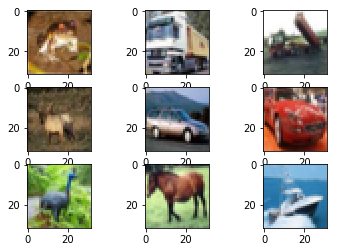

In [3]:
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

## Normalizing data
The `CIFAR-10` problem is best solved using a Convolutional Neural Network (CNN). The pixel values are in the range of `0` to `255` for each of the red, green and blue channels. Because the input values are well understood, we can easily normalize to the range `0` to `1` by dividing each value by the maximum observation which is `255`.   
`astype()` will copy the array, and cast to a specified type. `float32` is single precision float, sign bit, 8 bits exponent and 23 bits mantissa.


In [4]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

## Initializing Lable   
We can use a one hot encoding to transform them into a binary matrix in order to best model the classification problem. We know there are 10 classes for this problem, so we can expect the binary matrix to have a width of 10.
`to_categorical` can convert a class vector (integers) to binary class matrix.

In [5]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Building and evaluating our model
The codes below show the basic convnet looks like.It's a stack of `Conv2D` and `MaxPooling2D` layers.   
A convnet takes as input tensors of shape (image_channels, image_height, image_width). In our case, we will configure our convnet to process inputs of size (3, 32, 32), which is the format of `CIFAR-10` images. We do this via passing the argument input_shape=(3, 32, 32) to our first layer.   
- Convolutional input layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
- Dropout layer at 20% (Set a `DropOut` layer and the dropout rate as 0.2 to avoid overfitting problems.).
- Convolutional layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
- Max Pool layer with size 2×2.
- Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
- Dropout layer at 20%.
- Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
- Max Pool layer with size 2×2.
- Convolutional layer, 128 feature maps with a size of 3×3 and a rectifier activation function.
- Dropout layer at 20%.
- Convolutional layer,128 feature maps with a size of 3×3 and a rectifier activation function.
- Max Pool layer with size 2×2.
Let's display the architecture of our convnet so far:

In [6]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

The next step would be to feed our last output tensor (of shape (128, 4, 4)) into a densely-connected classifier network like those you are already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few Dense layers on top:
- Add flatten layer.
- Set dropout layer at 20%.
- Add fully connected layer with 1024 units and a rectifier activation function.
- Set dropout layer at 20%.
- Add fully connected layer with 512 units and a rectifier activation function.
- Set dropout layer at 20%.
- Add fully connected output layer with 10 units and a softmax activation function.   

For the optimizer of this model , the learning rate is 0.01, momentum is 0.9, learning rate will decay over each update and would not apply Nesterov momentum.
The loss function is categorical cross entropy and the model will be trained for 25 epochs.

In [7]:
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Let's display the architecture of our network so far:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
__________

Running this example prints the classification accuracy and loss on the training and test datasets each epoch.

In [12]:
numpy.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 17s 336us/step - loss: 1.9344 - acc: 0.2897 - val_loss: 1.7197 - val_acc: 0.3805
Epoch 2/25
50000/50000 [==============================] - 14s 278us/step - loss: 1.5214 - acc: 0.4482 - val_loss: 1.3466 - val_acc: 0.5130
Epoch 3/25
50000/50000 [==============================] - 14s 280us/step - loss: 1.3330 - acc: 0.5182 - val_loss: 1.2965 - val_acc: 0.5305
Epoch 4/25
50000/50000 [==============================] - 14s 281us/step - loss: 1.2033 - acc: 0.5676 - val_loss: 1.1245 - val_acc: 0.6003
Epoch 5/25
50000/50000 [==============================] - 14s 278us/step - loss: 1.1010 - acc: 0.6056 - val_loss: 1.0749 - val_acc: 0.6163
Epoch 6/25
50000/50000 [==============================] - 14s 277us/step - loss: 1.0099 - acc: 0.6400 - val_loss: 0.9640 - val_acc: 0.6607
Epoch 7/25
50000/50000 [==============================] - 14s 282us/step - loss: 0.9316 - acc: 0.6684 - val_loss: 0.

Here is the visulize function utilizing the `maiplotlib`. First diagram set the `Epoch` as its X axis, and set the `Accuracy` as its Y axis.

In [40]:
def showModel(history):
    %matplotlib inline
    plt.subplot(1,2,1);
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.subplot(1,2,2);
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()
    plt.show()

As we can seen , we save the history of the model and use `matplotlib` to demonstrate the accuracy and loss of total processes of model training. This model overfitting at about `12` epoches.

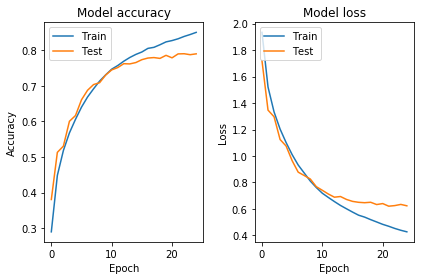

In [41]:
showModel(history)

## Extensions To Improve Model Performance

### 1. Training for More Epochs.    
Each model was trained for a very small number of epochs, `25`. It is common to train large convolutional neural networks for hundreds or thousands of epochs. Here is a optimised model that already be trained by 500 epoches. We can see its accuracy reach to `0.82`.

In [42]:
epochs = 200   # change to 500
numpy.random.seed(seed)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 13s 259us/step - loss: 0.4187 - acc: 0.8524 - val_loss: 0.6066 - val_acc: 0.7921
Epoch 2/200
50000/50000 [==============================] - 11s 217us/step - loss: 0.3963 - acc: 0.8585 - val_loss: 0.6144 - val_acc: 0.7933
Epoch 3/200
50000/50000 [==============================] - 11s 224us/step - loss: 0.3980 - acc: 0.8597 - val_loss: 0.6283 - val_acc: 0.7936
Epoch 4/200
50000/50000 [==============================] - 11s 218us/step - loss: 0.3842 - acc: 0.8628 - val_loss: 0.6109 - val_acc: 0.7973
Epoch 5/200
50000/50000 [==============================] - 11s 226us/step - loss: 0.3713 - acc: 0.8653 - val_loss: 0.6010 - val_acc: 0.8009
Epoch 6/200
50000/50000 [==============================] - 11s 222us/step - loss: 0.3594 - acc: 0.8715 - val_loss: 0.6156 - val_acc: 0.7977
Epoch 7/200
50000/50000 [==============================] - 11s 223us/step - loss: 0.3512 - acc: 0.8755 - val_l

Epoch 59/200
50000/50000 [==============================] - 22s 447us/step - loss: 0.1393 - acc: 0.9501 - val_loss: 0.7070 - val_acc: 0.8134
Epoch 60/200
50000/50000 [==============================] - 24s 473us/step - loss: 0.1423 - acc: 0.9488 - val_loss: 0.6879 - val_acc: 0.8095
Epoch 61/200
50000/50000 [==============================] - 22s 433us/step - loss: 0.1372 - acc: 0.9507 - val_loss: 0.6995 - val_acc: 0.8103
Epoch 62/200
50000/50000 [==============================] - 22s 446us/step - loss: 0.1379 - acc: 0.9508 - val_loss: 0.6885 - val_acc: 0.8095
Epoch 63/200
50000/50000 [==============================] - 22s 444us/step - loss: 0.1332 - acc: 0.9519 - val_loss: 0.6981 - val_acc: 0.8121
Epoch 64/200
50000/50000 [==============================] - 22s 449us/step - loss: 0.1352 - acc: 0.9516 - val_loss: 0.7039 - val_acc: 0.8089
Epoch 65/200
50000/50000 [==============================] - 22s 445us/step - loss: 0.1350 - acc: 0.9525 - val_loss: 0.6945 - val_acc: 0.8127
Epoch 66/200


Epoch 117/200
50000/50000 [==============================] - 32s 636us/step - loss: 0.0888 - acc: 0.9684 - val_loss: 0.7517 - val_acc: 0.8173
Epoch 118/200
50000/50000 [==============================] - 29s 580us/step - loss: 0.0889 - acc: 0.9677 - val_loss: 0.7614 - val_acc: 0.8182
Epoch 119/200
50000/50000 [==============================] - 29s 575us/step - loss: 0.0869 - acc: 0.9694 - val_loss: 0.7550 - val_acc: 0.8177
Epoch 120/200
50000/50000 [==============================] - 28s 567us/step - loss: 0.0902 - acc: 0.9670 - val_loss: 0.7400 - val_acc: 0.8200
Epoch 121/200
50000/50000 [==============================] - 28s 557us/step - loss: 0.0885 - acc: 0.9688 - val_loss: 0.7592 - val_acc: 0.8155
Epoch 122/200
50000/50000 [==============================] - 29s 570us/step - loss: 0.0912 - acc: 0.9687 - val_loss: 0.7568 - val_acc: 0.8177
Epoch 123/200
50000/50000 [==============================] - 28s 563us/step - loss: 0.0857 - acc: 0.9701 - val_loss: 0.7672 - val_acc: 0.8182
Epoch 

50000/50000 [==============================] - 17s 342us/step - loss: 0.0683 - acc: 0.9759 - val_loss: 0.7905 - val_acc: 0.8208
Epoch 175/200
50000/50000 [==============================] - 17s 342us/step - loss: 0.0704 - acc: 0.9748 - val_loss: 0.7823 - val_acc: 0.8204
Epoch 176/200
50000/50000 [==============================] - 21s 421us/step - loss: 0.0704 - acc: 0.9753 - val_loss: 0.7778 - val_acc: 0.8208
Epoch 177/200
50000/50000 [==============================] - 20s 404us/step - loss: 0.0658 - acc: 0.9772 - val_loss: 0.7807 - val_acc: 0.8205
Epoch 178/200
50000/50000 [==============================] - 22s 434us/step - loss: 0.0657 - acc: 0.9771 - val_loss: 0.7926 - val_acc: 0.8199
Epoch 179/200
50000/50000 [==============================] - 22s 444us/step - loss: 0.0688 - acc: 0.9765 - val_loss: 0.7918 - val_acc: 0.8176
Epoch 180/200
50000/50000 [==============================] - 25s 502us/step - loss: 0.0672 - acc: 0.9764 - val_loss: 0.7905 - val_acc: 0.8205
Epoch 181/200
50000/

In this method, we add more epoches for our model. It is obvious that the accuracy goes up. But simply add the epoches could lead the model learn a lot of unnecessary features and get overfitting. And we will introduce another method called data augmentation. And I generated the accuracy and loss images on the bottom.

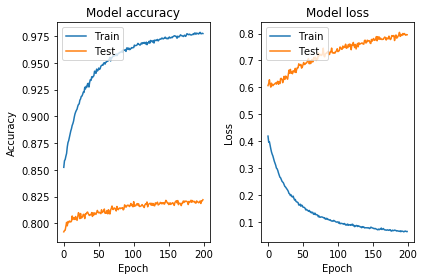

In [43]:
showModel(history)

### 2. Image Data Augmentation   
  
You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high-dimensional, like images.

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. `ImageDataGenerator` will generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).Let's get started with an example:

In [45]:
batch_size = 32
epochs = 30
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

After we add the data augumentation part, we can fit the model on the batches generated by `datagen.flow()`.

In [46]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        workers=4)

Epoch 1/30
1563/1563 [==============================] - 40s 26ms/step - loss: 0.6505 - acc: 0.7945 - val_loss: 0.5669 - val_acc: 0.8139
Epoch 2/30
1563/1563 [==============================] - 41s 26ms/step - loss: 0.5795 - acc: 0.8033 - val_loss: 0.5696 - val_acc: 0.8138
Epoch 3/30
1563/1563 [==============================] - 39s 25ms/step - loss: 0.5711 - acc: 0.8057 - val_loss: 0.5501 - val_acc: 0.8202
Epoch 4/30
1563/1563 [==============================] - 40s 26ms/step - loss: 0.5663 - acc: 0.8062 - val_loss: 0.5524 - val_acc: 0.8182
Epoch 5/30
1563/1563 [==============================] - 40s 26ms/step - loss: 0.5577 - acc: 0.8098 - val_loss: 0.5436 - val_acc: 0.8189
Epoch 6/30
1563/1563 [==============================] - 41s 26ms/step - loss: 0.5500 - acc: 0.8128 - val_loss: 0.5426 - val_acc: 0.8187
Epoch 7/30
1563/1563 [==============================] - 39s 25ms/step - loss: 0.5418 - acc: 0.8145 - val_loss: 0.5377 - val_acc: 0.8207
Epoch 8/30
1563/1563 [==========================

Evaluating our model at last.  As we can seen its accuracy increased from `0.80` to `0.85`. And this model did not overfitting in the early stage like the former model.

10000/10000 [==============================] - 6s 640us/step
('Test loss:', 0.5014915797710419)
('Test accuracy:', 0.8333)


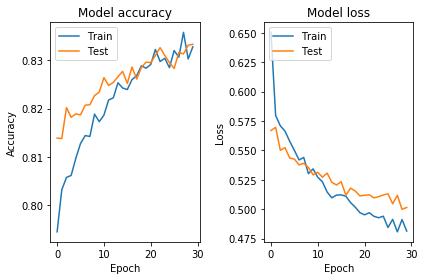

In [47]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
showModel(history)